# Model Parser Example

Demo of how to query for an existing model that is already in a database

## Import Libraries and Database Connection

In [ ]:
# Specify the CIM profile version, using GridAPPS-D extensions, ver. 2021
import importlib
cim_profile = 'rc4_2021'
cim = importlib.import_module('cimgraph.data_profile.' + cim_profile)
sparql = importlib.import_module('cimgraph.loaders.sparql.' + cim_profile)

In [ ]:
# Import Distributed Topology Processor
from topology_processor import DistributedTopology

In [ ]:
# Import CIMantic Graphs database connection and models
from cimgraph.loaders import Parameter, ConnectionParameters
from cimgraph.loaders.blazegraph.blazegraph import BlazegraphConnection
from cimgraph.models import DistributedModel
import json

In [ ]:
# Connect to Blazegraph Database
params = ConnectionParameters([Parameter(key="url", value="http://localhost:8889/bigdata/namespace/kb/sparql")])
bg = BlazegraphConnection(params, 'rc4_2021')

## Build CIM-Graph Python Property Graph

In [ ]:
# Create Feeder object
feeder_mrid = "_49AD8E07-3BF9-A4E2-CB8F-C3722F837B62"  # 13 bus
feeder = cim.Feeder(mRID=feeder_mrid)

In [ ]:
# Run Distributed Topology Processor to create switch-delimited topological areas
Topology = DistributedTopology(bg, feeder_mrid)
topology_response = json.loads(Topology.create_switch_areas(feeder_mrid))

In [ ]:
# Create CIMantic Graphs model and initialize all CIM objects
network = DistributedModel(connection=bg, feeder=feeder, topology=topology_response['feeders'])

## Traversing the Property Graph

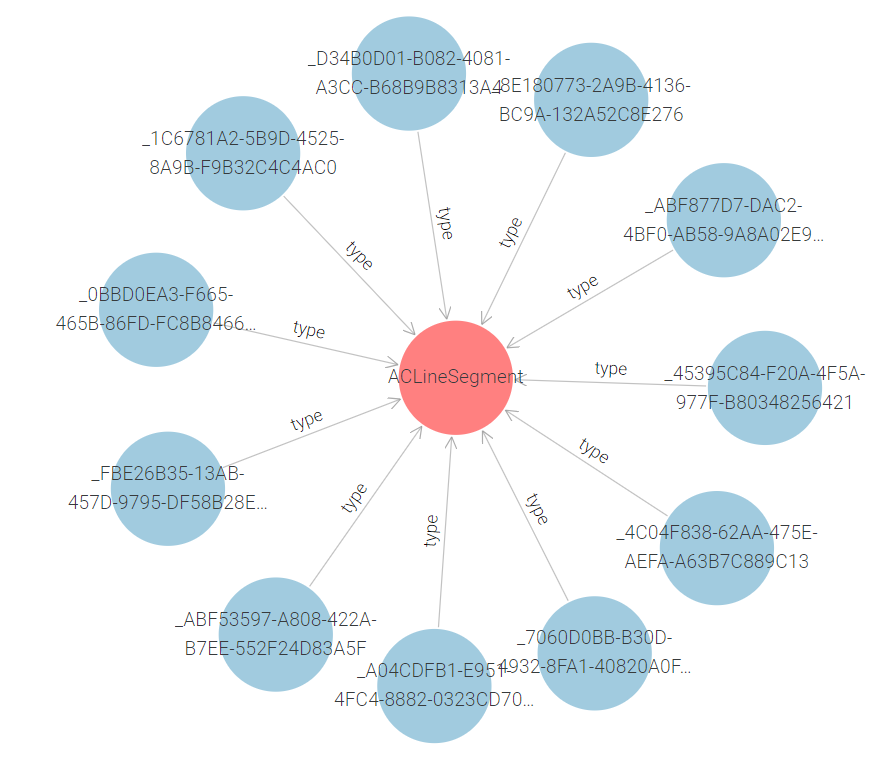

In [ ]:
network.pprint(cim.ACLineSegment)

## Example 1: Expand the Property Graph by One Edge

In [ ]:
network.get_all_attributes(cim.ACLineSegment)

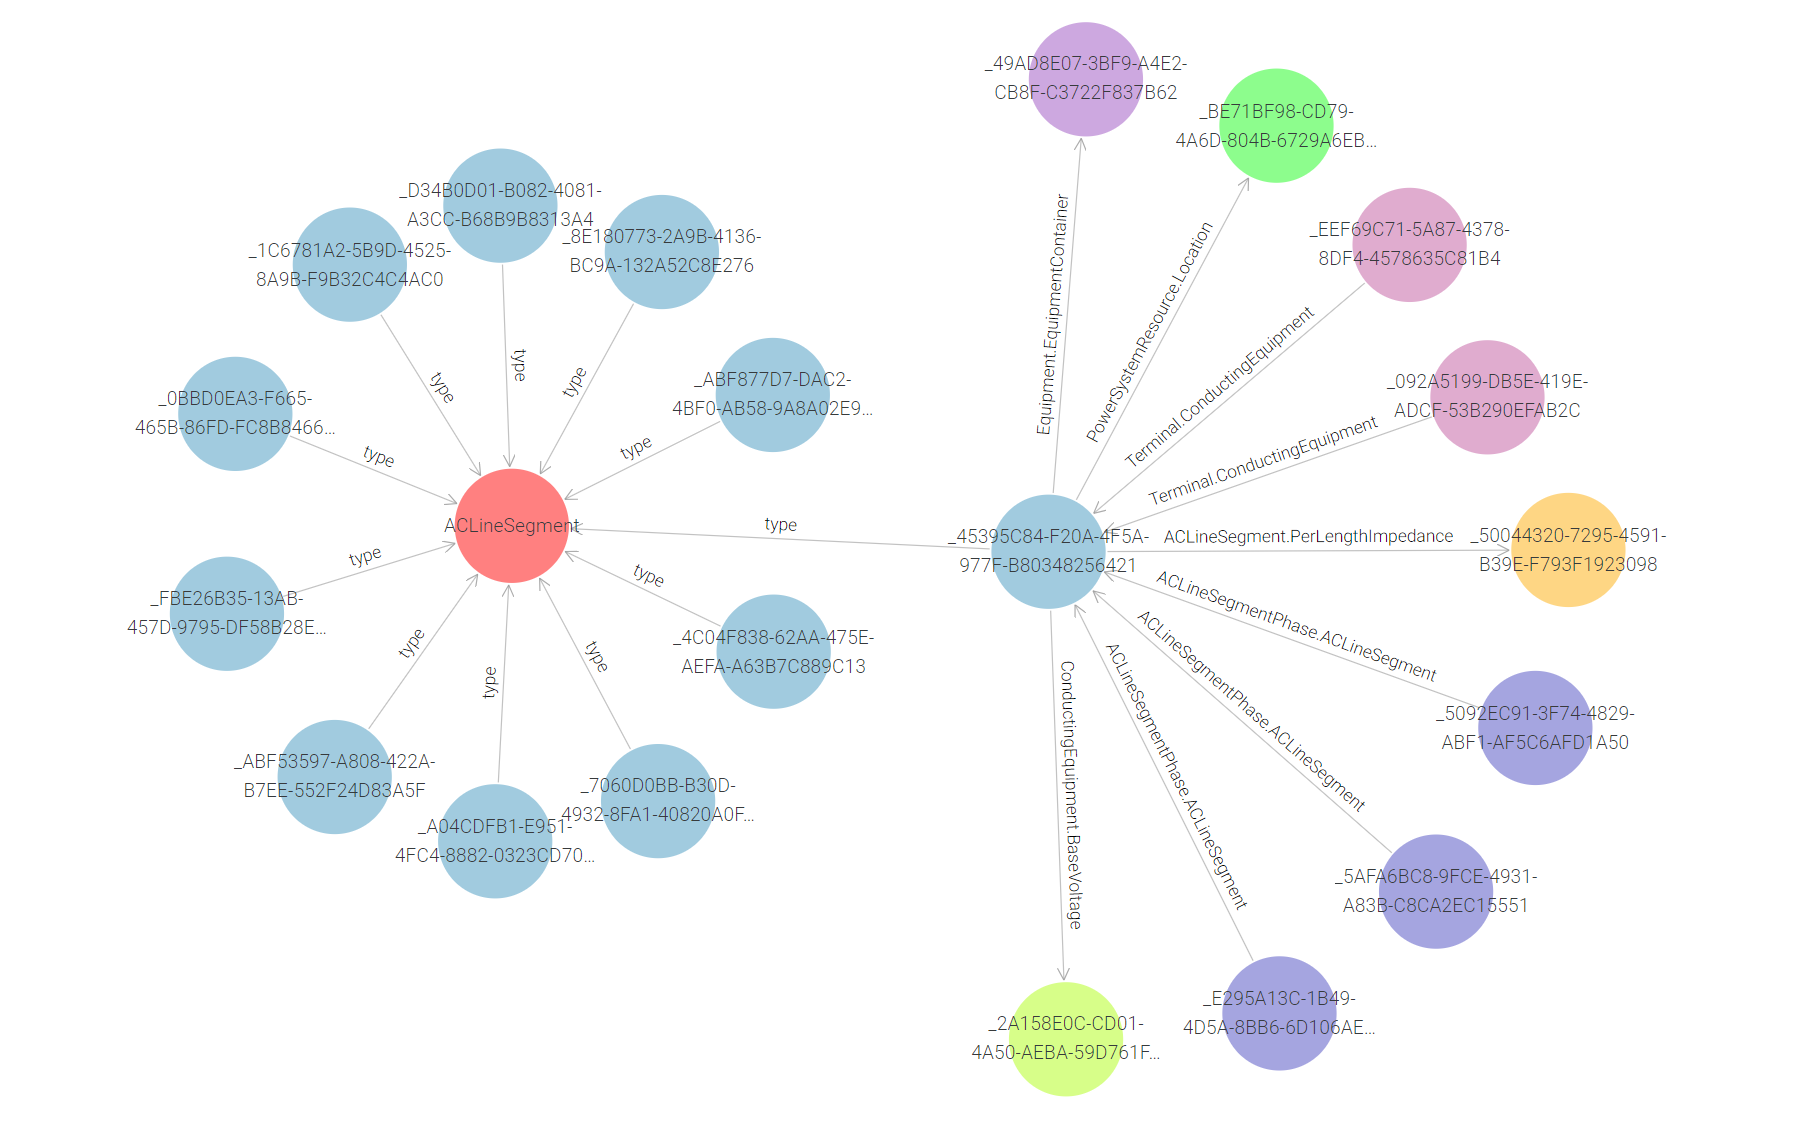

In [ ]:
network.pprint(cim.ACLineSegment)

## Example 2: Expand CIM-Graph to Find Bus and Phase of Each Line

In [ ]:
network.get_all_attributes(cim.ACLineSegment)
network.get_all_attributes(cim.ACLineSegmentPhase)
network.get_all_attributes(cim.Terminal)

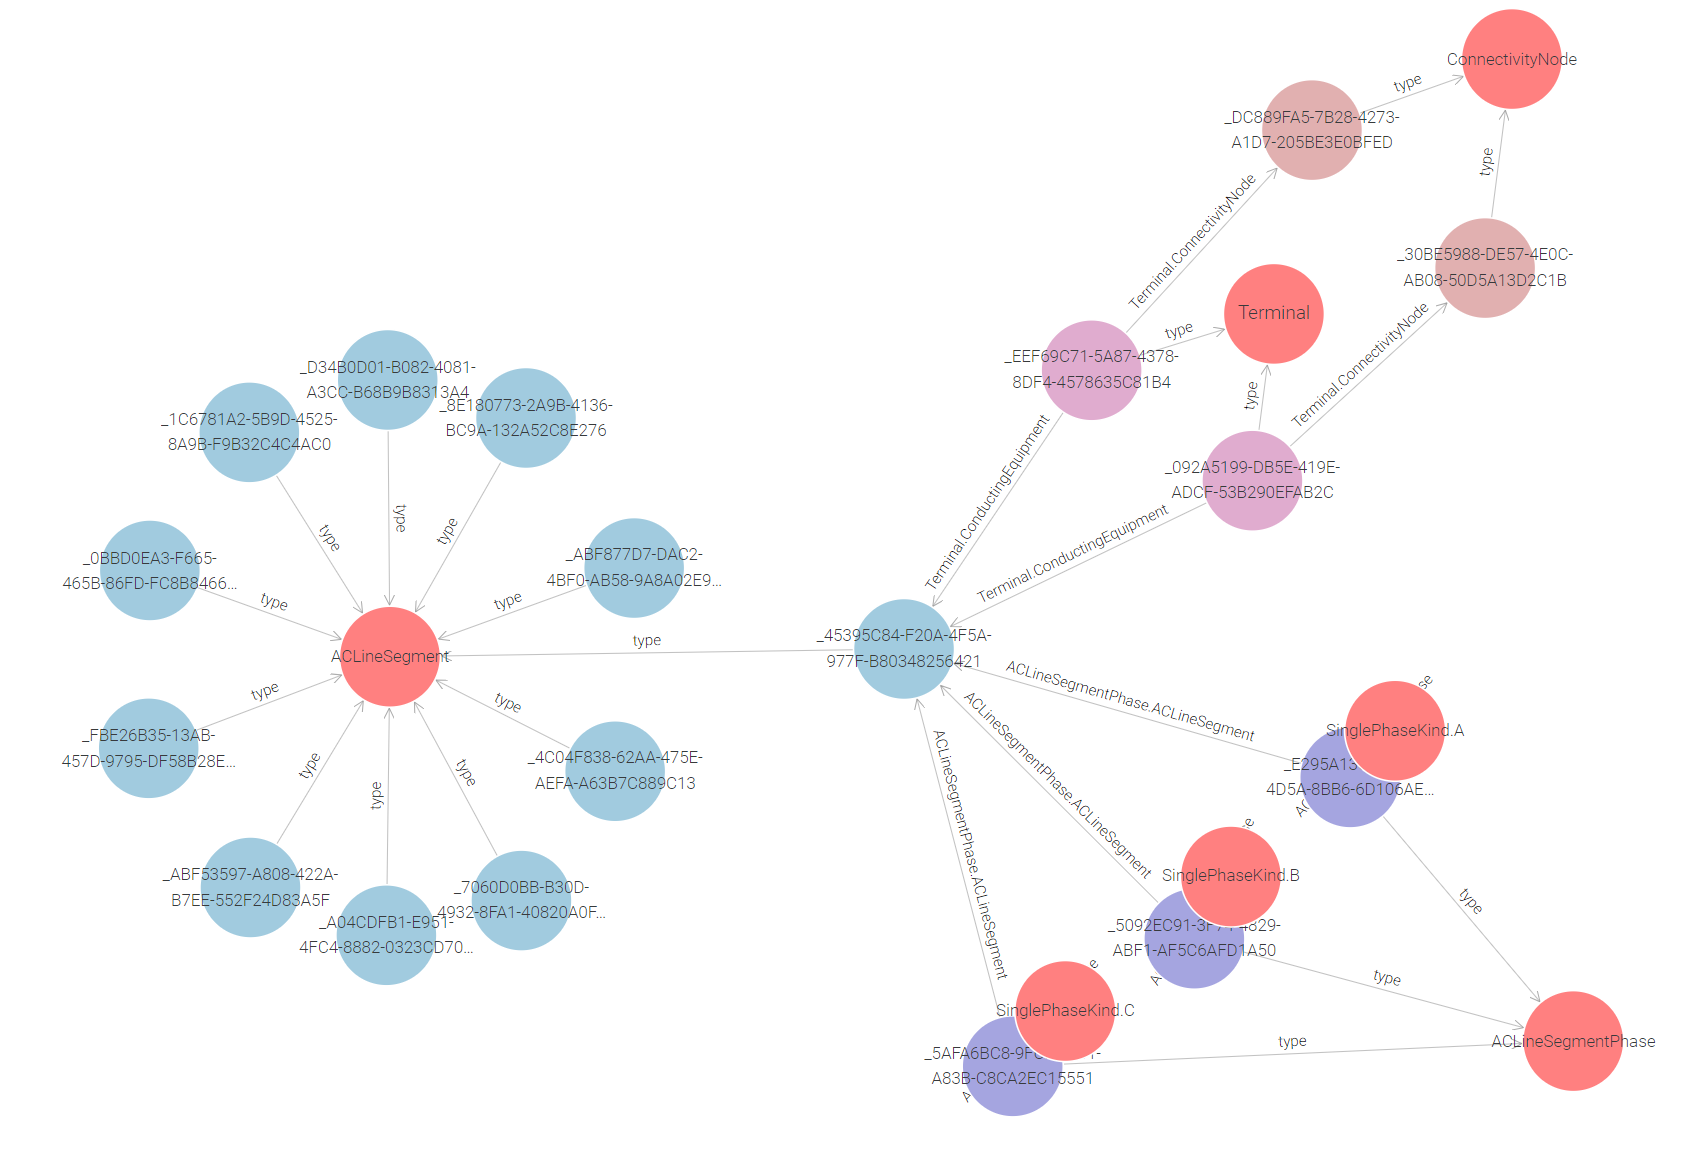

In [ ]:
network.pprint(cim.ACLineSegmentPhase)

In [ ]:
for line in network.typed_catalog[cim.ACLineSegment].values():
    print('\n line mrid: ',line.mRID)
    print('line name:', line.name)
    print('bus 1: ', line.Terminals[0].ConnectivityNode.name)
    print('bus 2: ', line.Terminals[1].ConnectivityNode.name)
    
    for line_phs in line.ACLineSegmentPhases:
        print('phase:', line_phs.phase, ', sequence:', line_phs.sequenceNumber)

## Example 3: Get All Measurements
All SCADA points are associated in memory with the correct power system objects

In [ ]:
network.get_all_attributes(cim.Analog)
network.get_all_attributes(cim.Discrete)

In [ ]:
for line in network.typed_catalog[cim.ACLineSegment].values():
    for meas in line.Measurements:
        print('Measurement: ', meas.name,  ', type:', meas.measurementType, ', phases:', meas.phases)

## Example 4: Restrict Results to Distributed Area / Microgrid

In [ ]:
# Specify which distributed topological area to use
network_area = network.switch_areas[4]

In [ ]:
# See all buses in the distributed area
network_area.pprint(cim.ConnectivityNode)

In [ ]:
# Get secondary network within the distributed area
secondary_area = network_area.secondary_areas[0]

In [ ]:
# See batteries
secondary_area.pprint(cim.BatteryUnit)

In [ ]:
# Get measurements for secondary area inverters
secondary_area.get_all_attributes(cim.PowerElectronicsConnection)
secondary_area.get_all_attributes(cim.Terminal)
secondary_area.get_all_attributes(cim.Analog)

In [ ]:
# Print all inverter measurements
for batt in secondary_area.typed_catalog[cim.PowerElectronicsConnection].values():
    for meas in batt.Measurements:
        print('Measurement: ', meas.name,  ', type:', meas.measurementType, ', phases:', meas.phases)

## Example 5: Get all line impedances and physical asset info

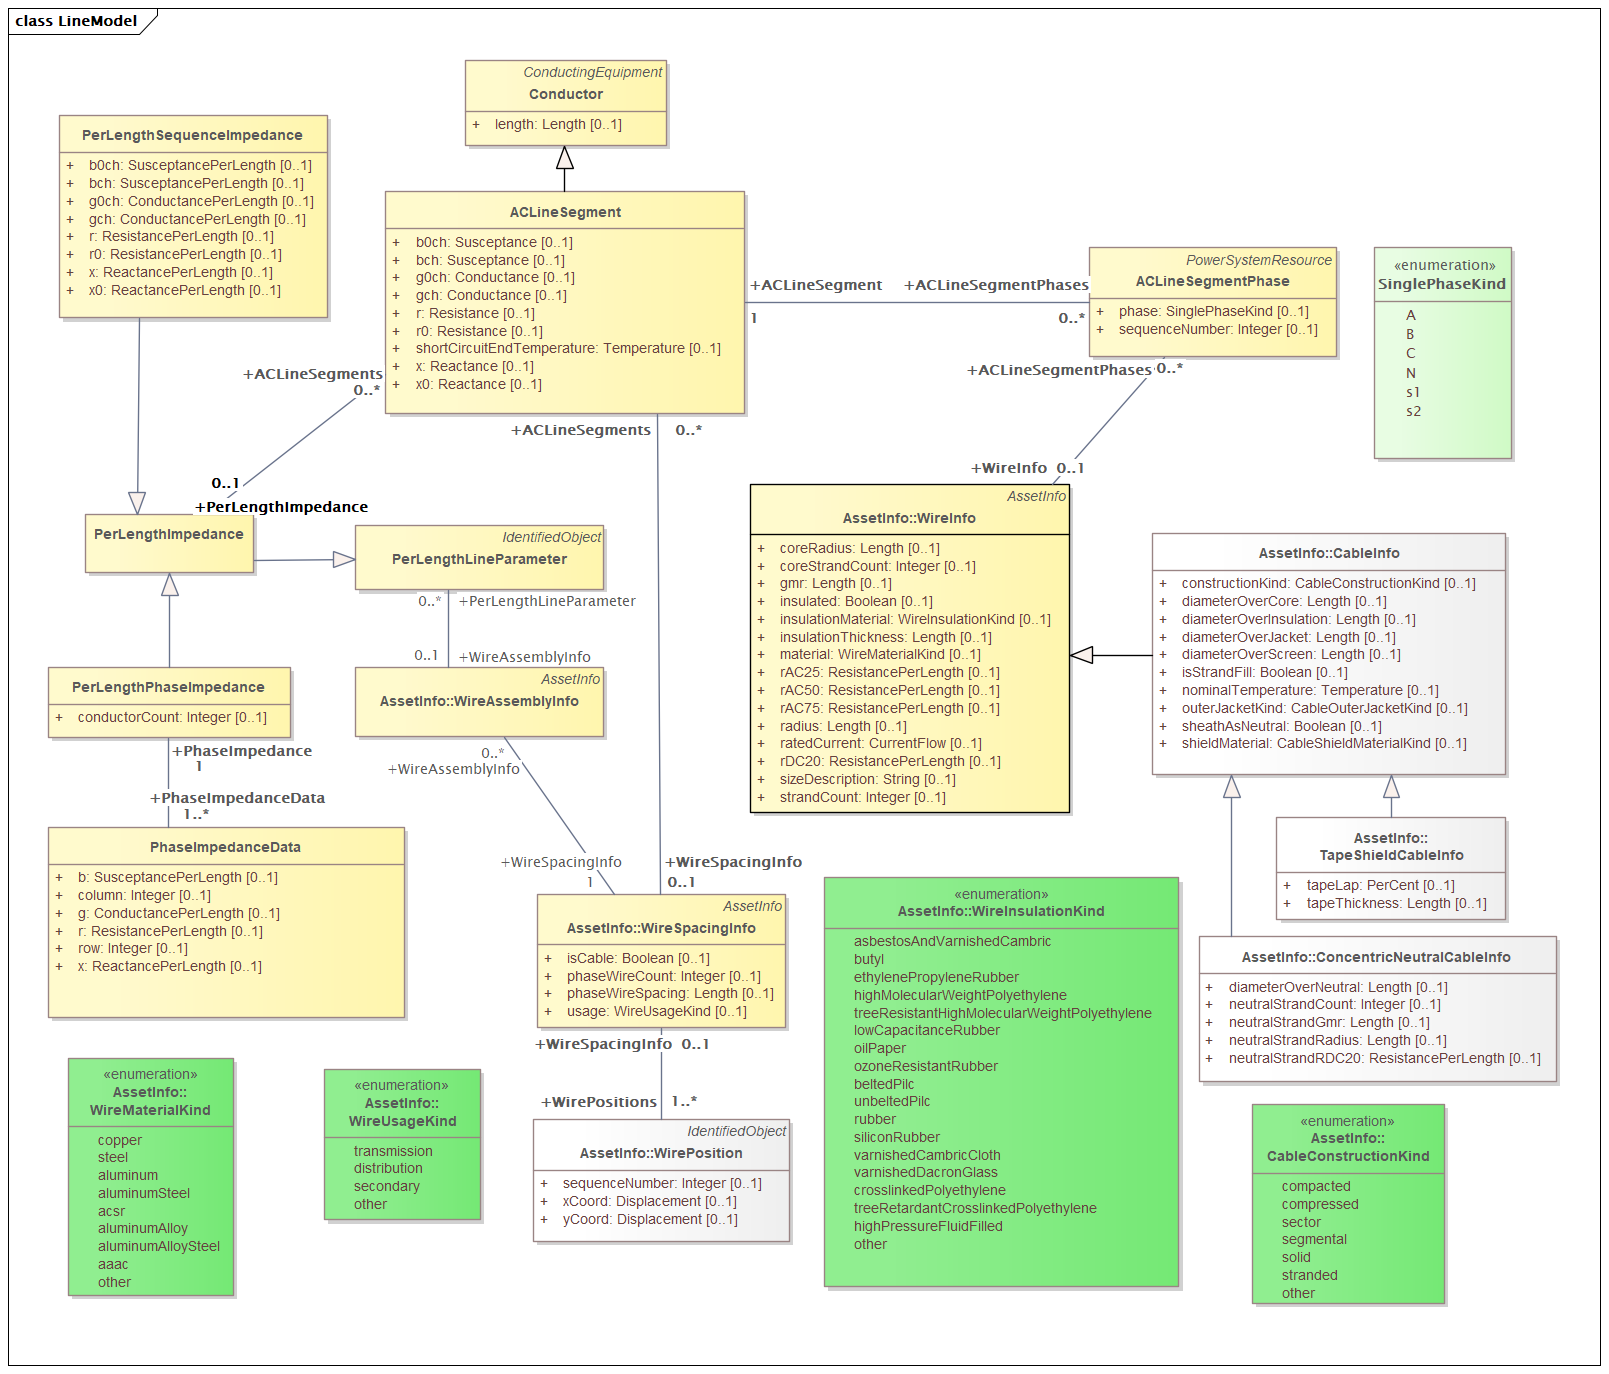

In [ ]:
network_area.get_all_attributes(cim.ACLineSegment)
network_area.get_all_attributes(cim.ACLineSegmentPhase)
network_area.get_all_attributes(cim.PerLengthPhaseImpedance)
network_area.get_all_attributes(cim.PhaseImpedanceData)
network_area.get_all_attributes(cim.WireSpacingInfo)
network_area.get_all_attributes(cim.WirePosition)
network_area.get_all_attributes(cim.OverheadWireInfo)
network_area.get_all_attributes(cim.ConcentricNeutralCableInfo)
network_area.get_all_attributes(cim.TapeShieldCableInfo)
network_area.get_all_attributes(cim.Terminal)

### Example 2.1: Parse by PSR:

In [ ]:
for line in network_area.typed_catalog[cim.ACLineSegment].values():
    print('\n line mrid: ', line.mRID)
    print('line name:', line.name)

    for line_phs in line.ACLineSegmentPhases:
        print('phase ', line_phs.phase, ': ', line_phs.mRID)
        if line_phs.WireInfo is not None:
            print('type: ', line_phs.WireInfo.__class__.__name__)
            print('gmr: ', line_phs.WireInfo.gmr)
            print('insulated: ', line_phs.WireInfo.insulated)

    if line.WireSpacingInfo is not None:
        for position in line.WireSpacingInfo.WirePositions:
            print('seq:', position.sequenceNumber, ' x:', position.xCoord, ' y:', position.yCoord)    

    if line.PerLengthImpedance is not None:
        for data in line.PerLengthImpedance.PhaseImpedanceData:
            print('row:', data.row, 'col:', data.column, 'r:', data.r, 'x:', data.x, 'b:', data.b)

### Example 2.2: Parse by Asset

In [ ]:
for impedance in network_area.typed_catalog[cim.PerLengthPhaseImpedance].values():
    print('\n name:', impedance.name)
    for data in impedance.PhaseImpedanceData:
            print('row:', data.row, 'col:', data.column, 'r:', data.r, 'x:', data.x, 'b:', data.b)
    for line in impedance.ACLineSegments:
        node1 = line.Terminals[0].ConnectivityNode
        node2 = line.Terminals[1].ConnectivityNode
        print('Line: ', line.name)
        print('Buses:', node1.name, node2.name)

## Get Asset Info for TransformerTank

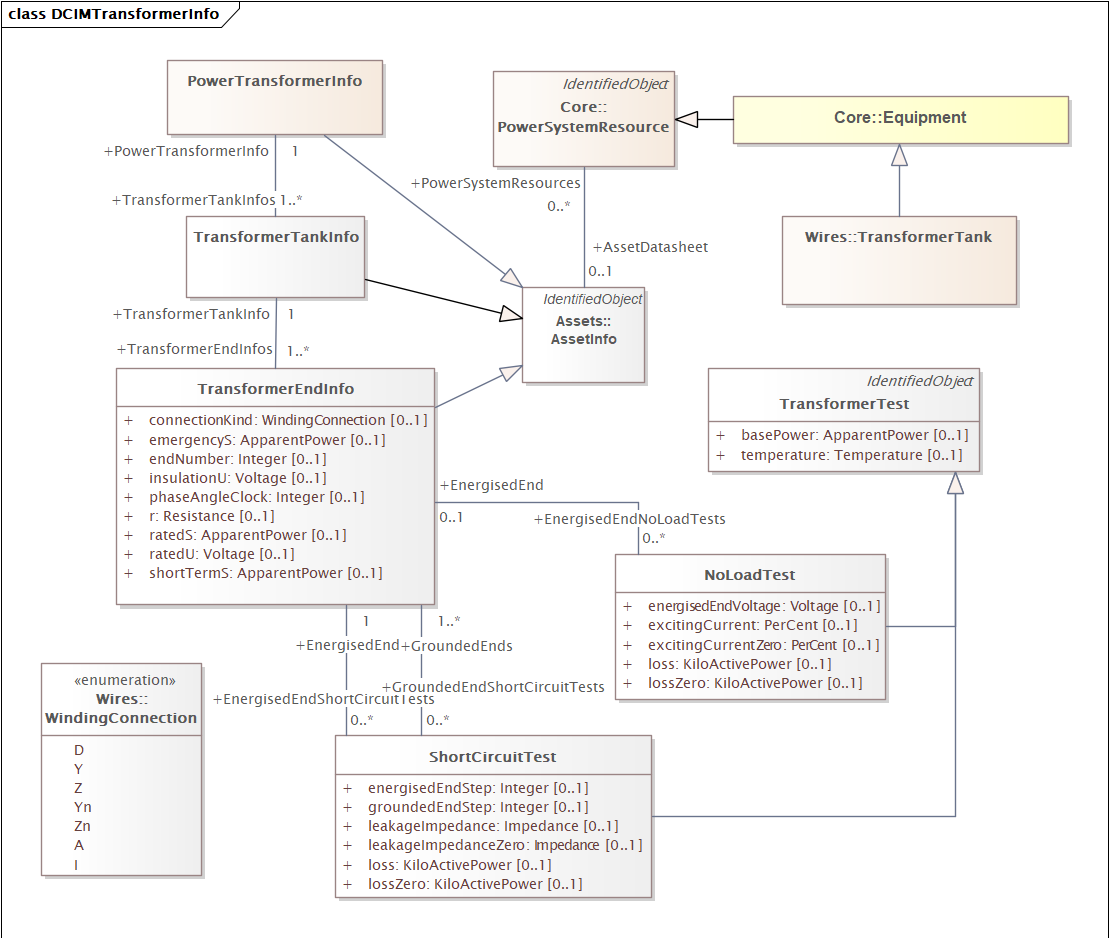

In [ ]:
network.get_all_attributes(cim.TransformerTank)
network.get_all_attributes(cim.TransformerTankEnd)
network.get_all_attributes(cim.TransformerTankInfo)
network.get_all_attributes(cim.TransformerEndInfo)
network.get_all_attributes(cim.ShortCircuitTest)
network.get_all_attributes(cim.NoLoadTest)
network.get_all_attributes(cim.Terminal)

In [ ]:
for tank in network.typed_catalog[cim.TransformerTank].values():
    print('\n name:', tank.name)
    for end in tank.TransformerTankEnds:
        print('end number:', end.endNumber)
        node = end.Terminal.ConnectivityNode
        print('bus: ', node.name)        
    
    for end_info in tank.TransformerTankInfo.TransformerEndInfos:
        
        print('end number', end_info.endNumber)
        print('rated voltage:', end_info.ratedU)
        print('resistance:', end_info.r)
        for no_load_test in end_info.EnergisedEndNoLoadTests:
            print('exciting current:', no_load_test.excitingCurrent)

        for short_circuit_test in end_info.EnergisedEndShortCircuitTests:
            print('energisedEndStep:', short_circuit_test.energisedEndStep)
            print('groundedEndStep:', short_circuit_test.groundedEndStep)
            print('leakageImpedance:', short_circuit_test.leakageImpedance)
            
        for short_circuit_test in end_info.GroundedEndShortCircuitTests:
            print('energisedEndStep:', short_circuit_test.energisedEndStep)
            print('groundedEndStep:', short_circuit_test.groundedEndStep)
            print('leakageImpedance:', short_circuit_test.leakageImpedance)
        

## Get PowerElectronicsConnection Inverters

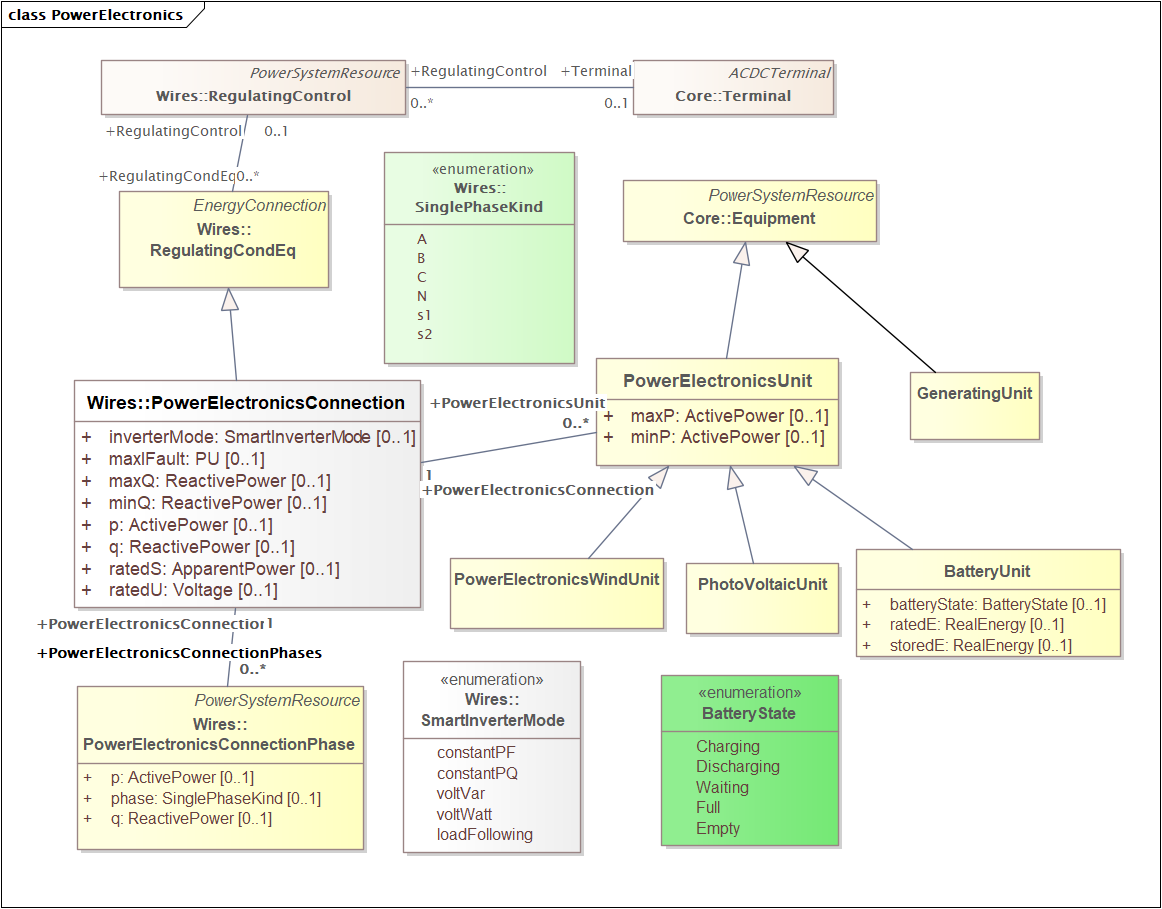

In [ ]:
secondary_area.get_all_attributes(cim.PowerElectronicsConnection)
secondary_area.get_all_attributes(cim.PowerElectronicsConnectionPhase)
secondary_area.get_all_attributes(cim.BatteryUnit)
secondary_area.get_all_attributes(cim.PhotovoltaicUnit)
secondary_area.get_all_attributes(cim.Terminal)

for pec in secondary_area.typed_catalog[cim.PowerElectronicsConnection].values():
    print('\n name: ', pec.name)
    print('p = ', pec.p, ', q = ', pec.q)
    for pec_phs in pec.PowerElectronicsConnectionPhases:
        print('phase ', pec_phs.phase, ':  p=', pec_phs.p, ', q=', pec_phs.q)
    
    for pec_unit in pec.PowerElectronicsUnit:
        print(pec_unit.__class__.__name__)
        if pec_unit.__class__ is cim.BatteryUnit:
            print('Stored E:', pec_unit.storedE)